In [1]:
# Install the ultralytics package using pip
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 25.6 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="l3ZRwINmzPuMzyjtYwHf")
project = rf.workspace("md-hasibul-islam-dhrubo").project("pavement-damage-detection-3")
version = project.version(2)
dataset = version.download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 28.0 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 20


Extracting Dataset Version Zip to Pavement-damage-detection--3-2 in yolov5pytorch:: 100%|██████████| 7792/7792 [00:01<00:00, 4046.16it/s]


In [4]:
my_new_model = YOLO('/kaggle/input/yolov8l-weights/yolov8l.pt')

In [5]:
new_image = '/kaggle/working/Pavement-damage-detection--3-2/test/images/IMG_20240308_133409_jpg.rf.a508cf0b9940fbf3d6f3baafcaa23647.jpg'
new_results = my_new_model.predict(new_image, conf=0.2)  #Adjust conf threshold



image 1/1 /kaggle/working/Pavement-damage-detection--3-2/test/images/IMG_20240308_133409_jpg.rf.a508cf0b9940fbf3d6f3baafcaa23647.jpg: 640x640 1 Crack, 1 pothole, 30.4ms
Speed: 6.1ms preprocess, 30.4ms inference, 492.4ms postprocess per image at shape (1, 3, 640, 640)


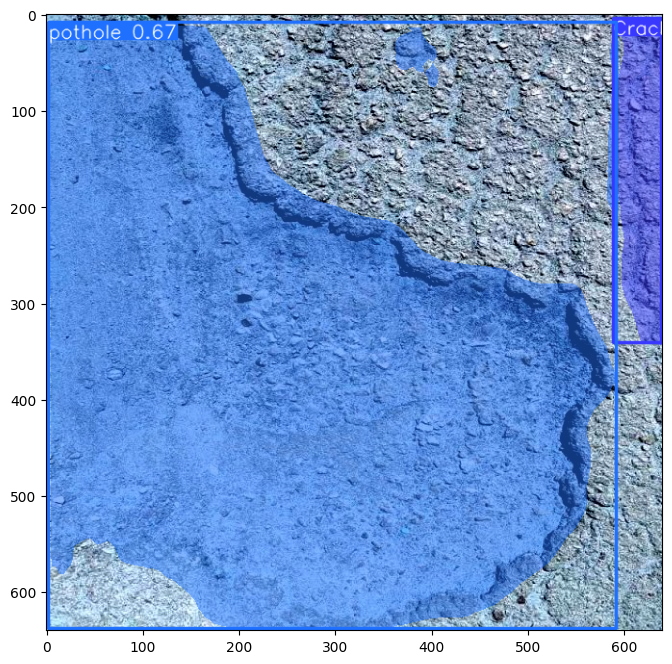

In [7]:
new_result_array = new_results[0].plot()
plt.figure(figsize=(8, 8))
plt.imshow(new_result_array)

In [14]:
new_result = new_results[0]
extracted_masks = new_result.masks.data
extracted_masks.shape
masks_array = extracted_masks.cpu().numpy()

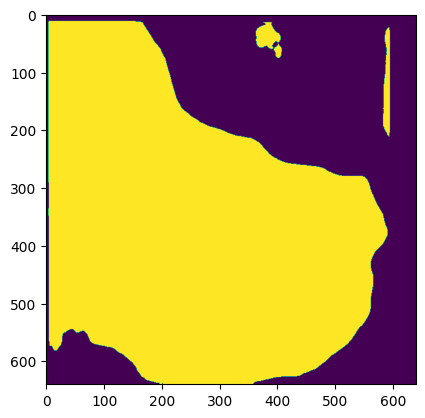

In [16]:
plt.imshow(masks_array[0])

In [17]:
class_names = new_result.names.values()
# Extract the boxes, which likely contain class IDs
detected_boxes = new_result.boxes.data
# Extract class IDs from the detected boxes
class_labels = detected_boxes[:, -1].int().tolist()
# Initialize a dictionary to hold masks by class
masks_by_class = {name: [] for name in new_result.names.values()}

# Iterate through the masks and class labels
for mask, class_id in zip(extracted_masks, class_labels):
    class_name = new_result.names[class_id]  # Map class ID to class name
    masks_by_class[class_name].append(mask.cpu().numpy())

dict_values(['Crack', 'Edgecrack', 'pothole'])

In [19]:
for class_name, masks in masks_by_class.items():
    print(f"Class Name: {class_name}, Number of Masks: {len(masks)}")


Class Name: Crack, Number of Masks: 1
Class Name: Edgecrack, Number of Masks: 0
Class Name: pothole, Number of Masks: 1


In [25]:
pothole_mask = masks_by_class['pothole']
crack_mask = masks_by_class['Crack']

In [26]:
# Extract the original image
orig_img = new_result.orig_img
orig_img.shape

(640, 640, 3)

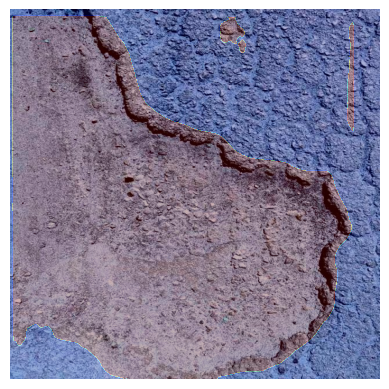

In [27]:
# Display the original image
plt.imshow(orig_img)

# Overlay the mask with some transparency
#plt.imshow(alpha_granule_masks[1], cmap='jet', alpha=0.3)
plt.imshow(pothole_mask[0], cmap='jet', alpha=0.3)
plt.axis('off') # Turn off axis labels
plt.show()

In [29]:
import pandas as pd
from skimage.measure import regionprops

# Initialize a list to store the properties
props_list = []

# Iterate through all classes
for class_name, masks in masks_by_class.items():
    # Iterate through the masks for this class
    for mask in masks:
        # Convert the mask to an integer type if it's not already
        mask = mask.astype(int)

        # Apply regionprops to the mask
        props = regionprops(mask)

        # Extract the properties you want (e.g., area, perimeter) and add them to the list
        for prop in props:
            area = prop.area
            perimeter = prop.perimeter
            # Add other properties as needed

            # Append the properties and class name to the list
            props_list.append({'Class Name': class_name, 'Area': area, 'Perimeter': perimeter})

# Convert the list of dictionaries to a DataFrame
props_df = pd.DataFrame(props_list)

# Now props_df contains the properties and class names for all regions

# Save the DataFrame to a CSV file
props_df.to_csv(index=False)

'Class Name,Area,Perimeter\nCrack,13998.0,752.7106781186548\npothole,258631.0,2851.492603517924\n'

In [30]:
props_df

,Class Name,Area,Perimeter
0,Crack,13998.0,752.710678
1,pothole,258631.0,2851.492604
